In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
sns.set()

os.chdir('../..')

DATA = Path('data')
RAW  = DATA/'raw'
PROCESSED = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)

In [4]:
from src.utils_k import add_type_features
from src.utils_j import generate_validation_set
from src.utils_f import duration_feature

In [6]:
%%time
test_session = pd.read_csv('data/raw/random_submission.csv')
test_tracking = pd.read_csv('data/raw/test_tracking.csv')
all_session = pd.read_csv('data/raw/train_session.csv') 
all_tracking = pd.read_csv('data/raw/train_tracking.csv')
productid_category = pd.read_csv('data/raw/productid_category.csv')

CPU times: user 57.4 s, sys: 5.78 s, total: 1min 3s
Wall time: 1min 22s


In [8]:
%%time
trn_session, trn_tracking, val_session, val_tracking = generate_validation_set(
                                                            all_session, 
                                                            all_tracking, 
                                                            test_size=0.4)

CPU times: user 966 ms, sys: 381 ms, total: 1.35 s
Wall time: 1.34 s


In [9]:
%%time
proc_train = add_type_features(trn_session[['sid']], trn_tracking)
proc_val = add_type_features(val_session[['sid']], val_tracking)
proc_all = add_type_features(all_session[['sid']], all_tracking)
proc_test = add_type_features(test_session, test_tracking)

CPU times: user 17.7 s, sys: 1.97 s, total: 19.7 s
Wall time: 19.7 s


In [10]:
%%time
proc_train = duration_feature(proc_train, trn_tracking)
proc_val = duration_feature(proc_val, val_tracking)
proc_all = duration_feature(proc_all, all_tracking)
proc_test = duration_feature(proc_test, test_tracking)

/anaconda/envs/kaggle/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


CPU times: user 13.9 s, sys: 956 ms, total: 14.9 s
Wall time: 14.9 s


In [28]:
trn_session.target.head()

87560     False
22460     False
127373     True
529       False
41467     False
Name: target, dtype: bool

In [32]:
for df, sess in zip([proc_train, proc_val, proc_all, proc_test], [trn_session, val_session, all_session, None]):
    df['target'] = list(sess['target']) if sess is not None else np.nan

In [40]:
cols = list(proc_train.columns)
proc_train = proc_train[cols]
proc_val = proc_val[cols]
proc_all = proc_all[cols]
proc_test = proc_test[cols]

In [41]:
%%time
proc_train.reset_index(drop=True).to_feather(PROCESSED/'proc_train.feather')
proc_val.reset_index(drop=True).to_feather(PROCESSED/'proc_val.feather')
proc_all.reset_index(drop=True).to_feather(PROCESSED/'proc_all.feather')
proc_test.reset_index(drop=True).to_feather(PROCESSED/'proc_test.feather')

CPU times: user 159 ms, sys: 198 ms, total: 356 ms
Wall time: 520 ms


## Checkpoint

In [42]:
proc_train = pd.read_feather(PROCESSED/'proc_train.feather')
proc_val = pd.read_feather(PROCESSED/'proc_val.feather')
proc_all = pd.read_feather(PROCESSED/'proc_all.feather')
proc_test = pd.read_feather(PROCESSED/'proc_test.feather')

/anaconda/envs/kaggle/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [45]:
cat_cols = []
target_col = 'target'
id_col = 'sid'
cont_cols = [x for x in proc_train.columns if x not in cat_cols + [target_col, id_col]]

In [47]:
import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1,
    'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(proc_train[cont_cols], label=proc_train[target_col])
d_valid = lgbm.Dataset(proc_val[cont_cols], label=proc_val[target_col])

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=100000, early_stopping_rounds=30, verbose_eval=100)

Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.284609
[200]	valid_0's binary_logloss: 0.278315
[300]	valid_0's binary_logloss: 0.275861
[400]	valid_0's binary_logloss: 0.274676
[500]	valid_0's binary_logloss: 0.274109
[600]	valid_0's binary_logloss: 0.273919
[700]	valid_0's binary_logloss: 0.273869
Early stopping, best iteration is:
[760]	valid_0's binary_logloss: 0.273846


## New session features

In [51]:
from scipy import stats

In [92]:
def add_session_metadata(session, tracking):
    rh = tracking.groupby('sid')['rh'].mean().to_dict()
    rw = tracking.groupby('sid')['rw'].mean().to_dict()
    device = tracking.dropna(subset=['device'], axis=0).groupby('sid')['device'].apply(lambda x: stats.mode(x)[0][0]).to_dict()
    siteid = tracking.dropna(subset=['siteid'], axis=0).groupby('sid')['siteid'].apply(lambda x: stats.mode(x)[0][0]).to_dict()
    session['rh'] = session.sid.map(rh)
    session['rw'] = session.sid.map(rw)
    session['device'] = session.sid.map(device)
    session['siteid'] = session.sid.map(siteid)

In [93]:
%%time
add_session_metadata(proc_train, trn_tracking)
add_session_metadata(proc_val, val_tracking)
add_session_metadata(proc_all, all_tracking)
add_session_metadata(proc_test, test_tracking)

/anaconda/envs/kaggle/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


CPU times: user 2min 4s, sys: 4.23 s, total: 2min 8s
Wall time: 2min 5s


In [101]:
# def add_area(session):
#     session['device_area'] = session.rh * session.rw

In [102]:
# %%time
# for df in [proc_train, proc_val, proc_all, proc_test]:
#     add_area(df)

CPU times: user 5.65 ms, sys: 62 µs, total: 5.71 ms
Wall time: 5.29 ms


In [141]:
%%time
proc_train.reset_index(drop=True).to_feather(PROCESSED/'proc_train.feather')
proc_val.reset_index(drop=True).to_feather(PROCESSED/'proc_val.feather')
proc_all.reset_index(drop=True).to_feather(PROCESSED/'proc_all.feather')
proc_test.reset_index(drop=True).to_feather(PROCESSED/'proc_test.feather')

CPU times: user 196 ms, sys: 220 ms, total: 417 ms
Wall time: 1.08 s


In [113]:
cat_cols = ['device', 'siteid']
target_col = 'target'
id_col = 'sid'
cont_cols = [x for x in proc_train.columns if x not in cat_cols + [target_col, id_col]]

In [98]:
from src.utils_r import to_cat_codes, apply_cats
to_cat_codes(proc_train, cat_cols)
apply_cats(proc_val, proc_train)

In [111]:
import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1,
    'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(proc_train[cont_cols + cat_cols], label=proc_train[target_col])
d_valid = lgbm.Dataset(proc_val[cont_cols + cat_cols], label=proc_val[target_col])

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=100000, early_stopping_rounds=30, verbose_eval=100)

/anaconda/envs/kaggle/lib/python3.6/site-packages/lightgbm/basic.py:725: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.284554
[200]	valid_0's binary_logloss: 0.278327
[300]	valid_0's binary_logloss: 0.275776
[400]	valid_0's binary_logloss: 0.274452
[500]	valid_0's binary_logloss: 0.273811
[600]	valid_0's binary_logloss: 0.27359
[700]	valid_0's binary_logloss: 0.273466
[800]	valid_0's binary_logloss: 0.273349
[900]	valid_0's binary_logloss: 0.273329
[1000]	valid_0's binary_logloss: 0.27333
Early stopping, best iteration is:
[980]	valid_0's binary_logloss: 0.273314


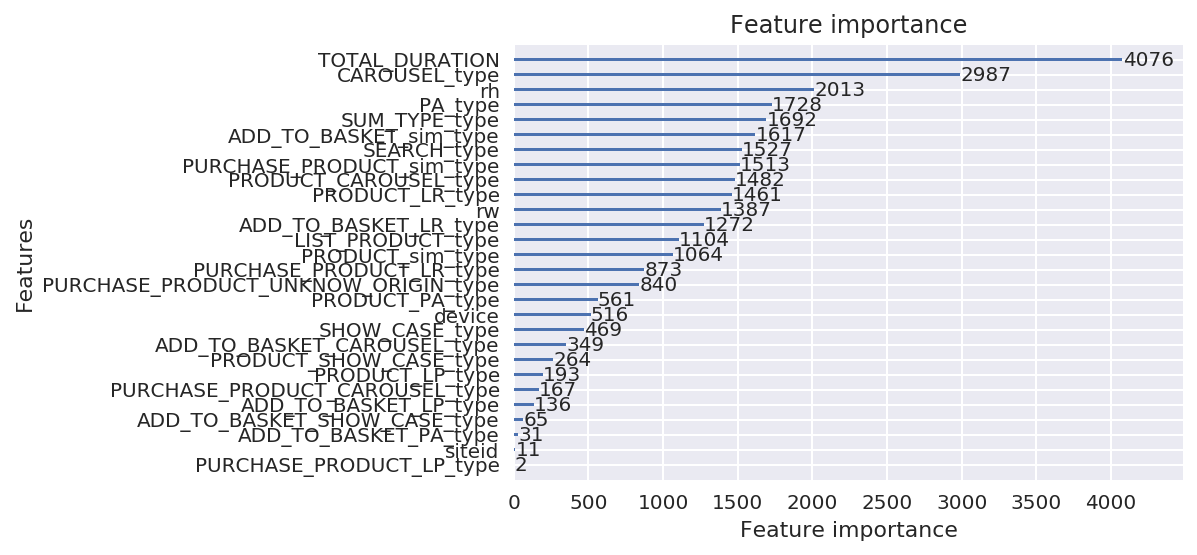

In [115]:
from lightgbm import plot_importance
plot_importance(clf)

## PCA

In [128]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(proc_all[cont_cols])
proc_train_norm = scaler.transform(proc_train[cont_cols])
proc_val_norm = scaler.transform(proc_val[cont_cols])
proc_all_norm = scaler.transform(proc_all[cont_cols])

In [129]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10).fit(proc_all_norm)
proc_train_pca = pca.transform(proc_train_norm)
proc_val_pca = pca.transform(proc_val_norm)

In [130]:
pca_cols = [f'PCA_{i+1:02}' for i in range(10)]
proc_train_pca = pd.DataFrame(proc_train_pca, columns=pca_cols)
proc_val_pca = pd.DataFrame(proc_val_pca, columns=pca_cols)

In [132]:
import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1,
    'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(pd.concat([proc_train[cont_cols + cat_cols],
                                  proc_train_pca], axis=1), 
                       label=proc_train[target_col])
d_valid = lgbm.Dataset(pd.concat([proc_val[cont_cols + cat_cols],
                                  proc_val_pca], axis=1), 
                       label=proc_val[target_col])

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=100000, early_stopping_rounds=30, verbose_eval=100)

/anaconda/envs/kaggle/lib/python3.6/site-packages/lightgbm/basic.py:725: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[100]	valid_0's binary_logloss: 0.284356
[200]	valid_0's binary_logloss: 0.278127
[300]	valid_0's binary_logloss: 0.27558
[400]	valid_0's binary_logloss: 0.27439
[500]	valid_0's binary_logloss: 0.273776
[600]	valid_0's binary_logloss: 0.273527
[700]	valid_0's binary_logloss: 0.273428
[800]	valid_0's binary_logloss: 0.273407
Early stopping, best iteration is:
[775]	valid_0's binary_logloss: 0.273393


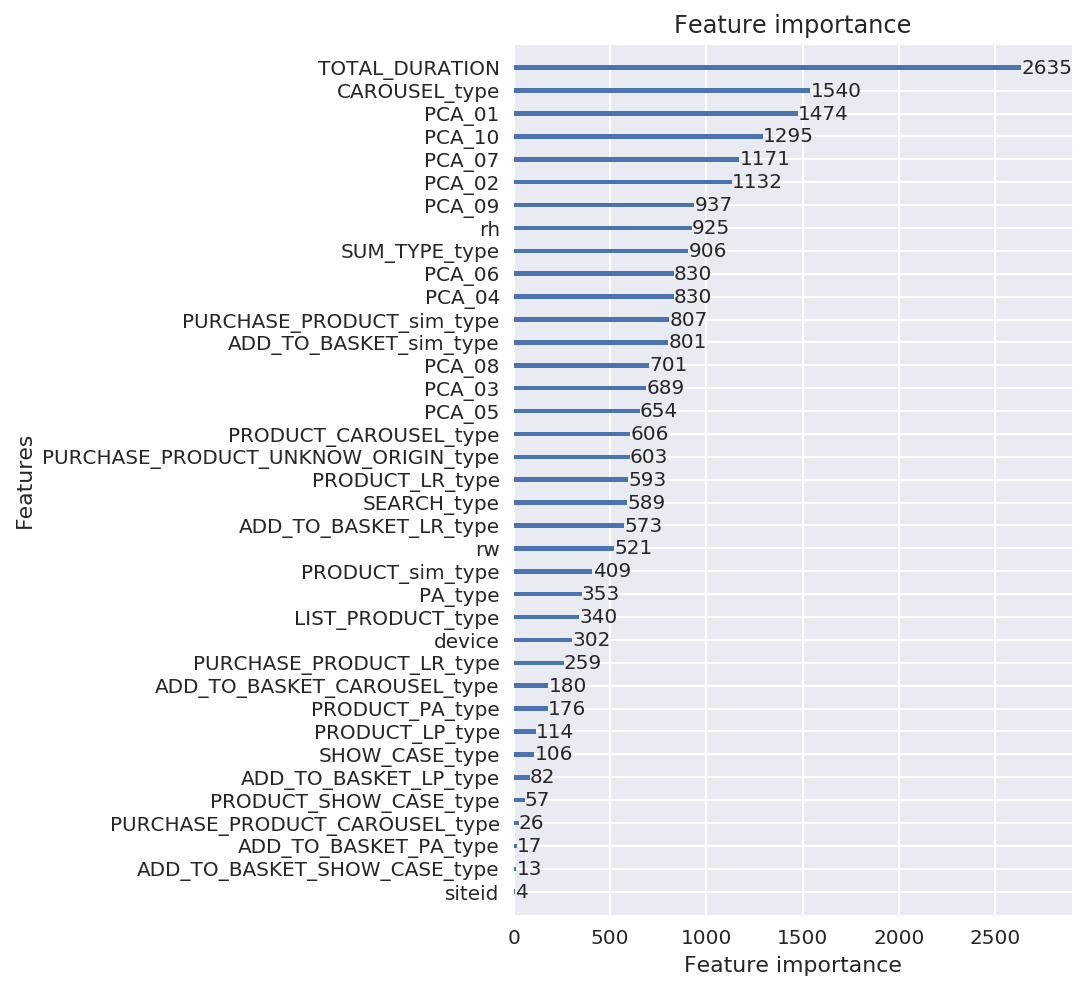

In [134]:
from lightgbm import plot_importance
plot_importance(clf, figsize=(5, 8))

## Test

In [135]:
proc_train = pd.read_feather(PROCESSED/'proc_train.feather')
proc_val = pd.read_feather(PROCESSED/'proc_val.feather')
proc_all = pd.read_feather(PROCESSED/'proc_all.feather')
proc_test = pd.read_feather(PROCESSED/'proc_test.feather')

/anaconda/envs/kaggle/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [140]:
%%time
for df in [proc_train, proc_val, proc_all, proc_test]:
    df.drop('device_area', axis=1, inplace=True)

CPU times: user 44.1 ms, sys: 28.1 ms, total: 72.1 ms
Wall time: 71.1 ms


In [144]:
cat_cols = ['device', 'siteid']
target_col = 'target'
id_col = 'sid'
cont_cols = [x for x in proc_train.columns if x not in cat_cols + [target_col, id_col]]

In [142]:
from src.utils_r import to_cat_codes, apply_cats
to_cat_codes(proc_all, cat_cols)
apply_cats(proc_test, proc_all)

In [146]:
%%time
import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1,
    'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(proc_all[cont_cols + cat_cols], label=proc_all[target_col])
d_test = lgbm.Dataset(proc_test[cont_cols + cat_cols])

clf = lgbm.train(params, d_train, num_boost_round=1000, verbose_eval=100)

In [149]:
proc_test[target_col] = clf.predict(proc_test[cont_cols + cat_cols])

In [151]:
proc_test[target_col].describe()

count    88750.000000
mean         0.094440
std          0.093376
min          0.010561
25%          0.037840
50%          0.057359
75%          0.097288
max          0.831377
Name: target, dtype: float64

In [152]:
test_session.head()

,sid,target
0,EhjG5b8h+RHDgxkQpkMc9sECXbdnA3JOPS07CRYvWmwYSJ...,0.548814
1,34lu87wJJunsPz2c0SxM/aLQ9x+2dlj5W96R95DIG9yRRe...,0.715189
2,xkSYpSt3qRk8X6Ev1W8d72Vj6oyXbI8DKjkCqHmvcaI36F...,0.602763
3,Tu9ylHPEk5Lw5K/8TpuJOEdJv3ZUzJu0zz2sfBrJDQpmyg...,0.544883
4,s6gbPkykrrtcYDB/OidLEdkEsk/bsWIejziprzhq2wJBij...,0.423655


In [153]:
proc_test[[id_col, target_col]].head()

,sid,target
0,EhjG5b8h+RHDgxkQpkMc9sECXbdnA3JOPS07CRYvWmwYSJ...,0.021799
1,34lu87wJJunsPz2c0SxM/aLQ9x+2dlj5W96R95DIG9yRRe...,0.019089
2,xkSYpSt3qRk8X6Ev1W8d72Vj6oyXbI8DKjkCqHmvcaI36F...,0.039694
3,Tu9ylHPEk5Lw5K/8TpuJOEdJv3ZUzJu0zz2sfBrJDQpmyg...,0.068080
4,s6gbPkykrrtcYDB/OidLEdkEsk/bsWIejziprzhq2wJBij...,0.057208


In [155]:
proc_test[[id_col, target_col]].to_csv(SUBMISSIONS/'robert_0_submit.csv', index=False)

## PCA

In [157]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
proc_eve = pd.concat([proc_all[cont_cols], proc_test[cont_cols]])
scaler.fit(proc_eve)
proc_all_norm = scaler.transform(proc_all[cont_cols])
proc_test_norm = scaler.transform(proc_test[cont_cols])
proc_eve_norm = scaler.transform(proc_eve[cont_cols])

In [158]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10).fit(proc_eve_norm)
proc_all_pca = pca.transform(proc_all_norm)
proc_test_pca = pca.transform(proc_test_norm)

In [159]:
pca_cols = [f'PCA_{i+1:02}' for i in range(10)]
proc_all_pca = pd.DataFrame(proc_all_pca, columns=pca_cols)
proc_test_pca = pd.DataFrame(proc_test_pca, columns=pca_cols)

In [160]:
import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1,
    'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(pd.concat([proc_all[cont_cols + cat_cols],
                                  proc_all_pca], axis=1), 
                       label=proc_all[target_col])

clf = lgbm.train(params, d_train, num_boost_round=1000, verbose_eval=100)

In [161]:
proc_test[target_col] = clf.predict(proc_test[cont_cols + cat_cols])

In [162]:
proc_test[target_col].describe()

count    88750.000000
mean         0.097626
std          0.071159
min          0.024472
25%          0.053315
50%          0.071005
75%          0.100166
max          0.689923
Name: target, dtype: float64

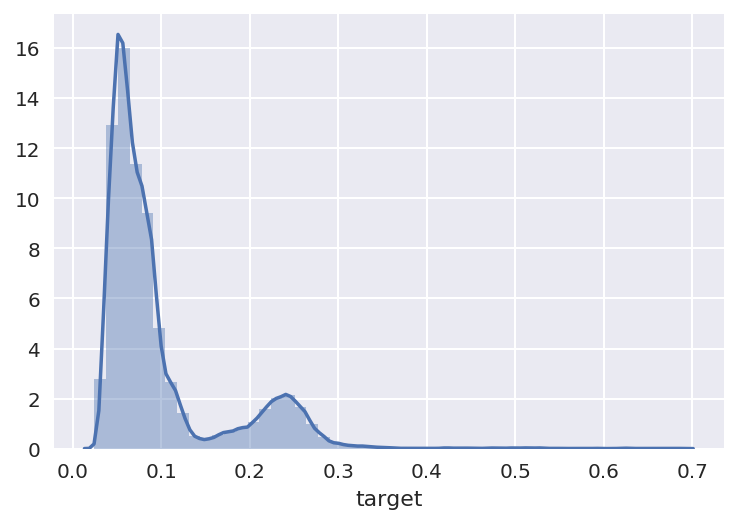

In [166]:
sns.distplot(proc_test[target_col])

In [163]:
proc_test[[id_col, target_col]].to_csv(SUBMISSIONS/'robert_1_submit.csv', index=False)

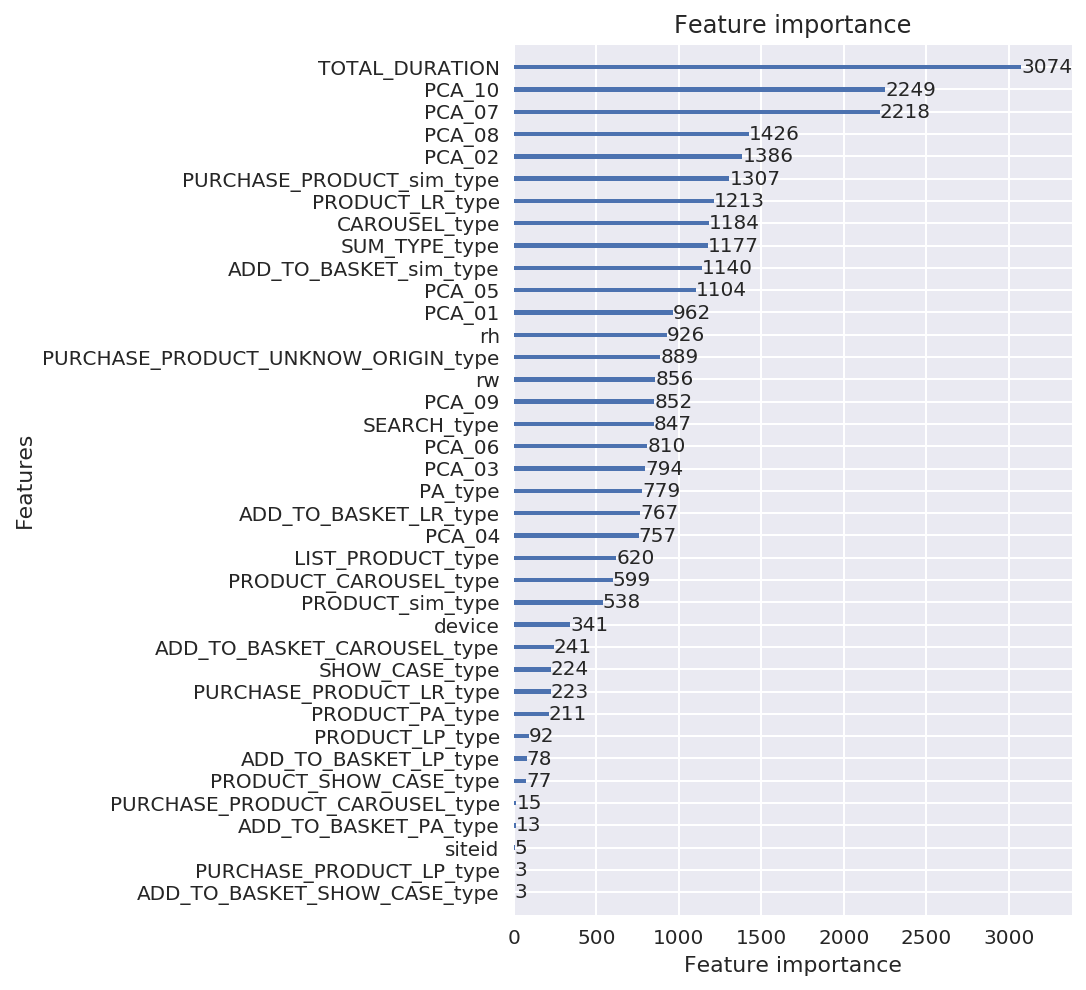

In [164]:
from lightgbm import plot_importance
plot_importance(clf, figsize=(5, 8))